# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

- Stakeholder 
    - Goat City Government/ Health Department
- Business problem:
    - GOAT city in random state is ordering Covid vaccines and is fully aware that not everyone will get the vaccine. GOAT city wants to know how many Covid vaccines they should be ordering.
- Target: H1N1
- Cost of different errors FP/FN
- False Positive: Model predicts they will get the vaccine, but didn't.
- Ordering too many vaccines and wasting money/material
- False Negative: Model predicts they won't get the vaccine, but did.
- Vaccine shortage. Loss of life.
- Metric:
  - Recall
  - F1-score

We need to download category_encoders to use it.

In [34]:
!pip install category_encoders

Import necessary tools.

In [35]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import category_encoders as ce

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.metrics import roc_curve, roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline

Import the datasets.

In [36]:
features_df = pd.read_csv('Data/training_set_features.csv')
lables_df = pd.read_csv('Data/training_set_labels.csv')

Lets look into the detail of each dataset. The features_df are X and the lables_df are y.  

In [37]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [38]:
lables_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   respondent_id     26707 non-null  int64
 1   h1n1_vaccine      26707 non-null  int64
 2   seasonal_vaccine  26707 non-null  int64
dtypes: int64(3)
memory usage: 626.1 KB


There are two variables in lables_df so we need to take out seasonal flu since our target will be H1N1.

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

Our X will be all the variables in features_df. y will be the 'h1n1 vaccine' survey data from lables_df. 

In [39]:
X = features_df
y = lables_df['h1n1_vaccine']

Lets checkout the NAN values.

In [40]:
X.isna().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

The column respondent_id will not show any trend and irrelevant. Therefore, we will drop it.

In [41]:
X.drop(columns=['respondent_id'], inplace= True)

The health_insurance / employment_industry / employment_occupation has more than 10k NAN values. Lets checkout.

In [42]:
X['health_insurance'].value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

Since it was a survey, we believe the NAN values for this columns was unanswered. Therefore, we will assign 2 for all the NAN values which will indicate 'unasnwered.'

In [43]:
X['health_insurance'].fillna(2)

0        1.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
26702    2.0
26703    1.0
26704    2.0
26705    0.0
26706    1.0
Name: health_insurance, Length: 26707, dtype: float64

Now, lets check the other two.

In [44]:
X['employment_industry'].value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [45]:
X['employment_occupation'].value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

Two columns cannot be just filled in with random object. Therefore, we will work on those columns using CountEncoder and SimpleImputer, which will be covered in next section.

### Pipeline

Following process was obtained from following citation:

- Berlin L. Lindseyberlin/Cat-in-the-dat-project. GitHub. https://github.com/lindseyberlin/Cat-in-the-Dat-Project. Published October 17, 2021. 

We will split the data into use set and hold set. Use set will be the one we will use to train and validate the model. Hold set will be our technical test set.

In [46]:
# split use and hold 
X_use, X_hold, y_use, y_hold = train_test_split(X, y, test_size=0.1, random_state=0)

# split train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
# initialize three columns
num_cols = []
ohe_cols = []
freq_cols = []

# make the list of columns
# num = any columns with numerical value
# ohe = any columns with object value with less than 10 unique values
# freq = any columns with object value with 10 or more unique values
for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

Let's check which columns are in each list.

In [48]:
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [49]:
ohe_cols

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'census_msa']

In [50]:
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

We will create pipeline for each types of cols for preprocessing.
- num: scale with MinMaxScaler and apply IterativeImputer to fill the NA values.
- ohe: apply SimpleImputer to fill NA values and encode with OneHotEncoder.
- freq: encode with CountEncoder and apply SimpleImputer to fill the NA values.

In [51]:
num_transformer = Pipeline(steps=[
    ('minmaxscaler', MinMaxScaler()),
    ('num_imputer', IterativeImputer(max_iter = 15))
    ])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('oh_encoder', OneHotEncoder(handle_unknown='ignore'))
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)),
    ('freq_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

Combine 3 pipelines using ColumnTransformer to create 1 preprocessor. Then, fit the preprocessor to X_train dataset.

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [53]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler()),
                                                 ('num_imputer',
                                                  IterativeImputer(max_iter=15))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doc...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

### 1. Logistic Regression

#### 1.1 Baseline Model

Our first model will be logistic regression. We will start with no parameters

In [54]:
# Create a pipeline combining preprocessor and classifier
# classifier = LogisticRegression()
lr_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [55]:
# Cross validate the model
cross_validate(lr_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([4.60519123, 4.35196161, 4.31042194, 4.29590201, 4.01465726]),
 'score_time': array([0.09908938, 0.09708691, 0.09708762, 0.09408474, 0.09108257]),
 'test_score': array([0.83781886, 0.83922303, 0.83758484, 0.83407442, 0.83079803]),
 'train_score': array([0.83582963, 0.83612216, 0.83618067, 0.83770185, 0.83840393])}

Cross validation shows that there is no overfitting.

In [56]:
# fit the model
lr_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [57]:
# Predict on validation set
lr_preds = lr_clf.predict(X_val)

Based on the prediction, we will caculate the metrics: accuracy, recall, f1, and roc_auc.

In [58]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, lr_preds)))
print('recall {:0.3f}'.format(recall_score(y_val, lr_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, lr_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , lr_preds)))

accuracy: 0.823
recall 0.403
f1: 0.498
roc_auc: 0.671


Although the accuracy is high, recall and f1 is less than 0.5. AUC might be at the higher side.

We will also generate the confusion matrix to visualize the FN/FP cases.

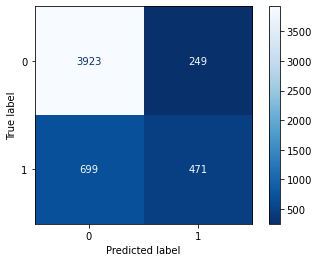

In [90]:
plot_confusion_matrix(lr_clf, X_val, y_val, cmap = 'Blues_r')

#### 1.2 Iteration

Lets try the gridsearch, we will look at 3 parameters for logistic regression:
- penalty
- C
- class_weight

In [26]:
params={'classifier__penalty':['l2', 'l1','elasticnet'],
        'classifier__C':[ 0.1, 1, 10, 100, 101, 102,103,104,105],
        'classifier__class_weight':['balanced', None]
       }

In [53]:
grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='f1')
output = grid_clf.fit(X_train, y_train)

In [54]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_clf.best_params_, 
                                                  grid_clf.best_score_))

Best Param:{'classifier__C': 0.1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}, Best f1:0.581


The result shows the best model is:
- C = 0.1
- class_weight = 'balanced'
- penalty = l2

#### 1.3 Model 2.0

The output with best estimator will be our model 2.0. We will go through the same process with that of model 1.0.

In [55]:
output.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [57]:
cross_validate(output.best_estimator_, X_train, y_train, return_train_score=True)

{'fit_time': array([4.12075019, 4.07371306, 4.07971311, 4.09673524, 3.81046033]),
 'score_time': array([0.09308457, 0.09408522, 0.09309196, 0.09408498, 0.08807945]),
 'test_score': array([0.77556752, 0.7856307 , 0.78633279, 0.77112099, 0.76316405]),
 'train_score': array([0.7788439 , 0.77784929, 0.77515797, 0.77937047, 0.78206178])}

Cross validation shows that there is no overfitting.

In [56]:
val_preds = output.best_estimator_.predict(X_val)

In [58]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, val_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, val_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, val_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , val_preds)))

accuracy: 0.773
recall: 0.712
f1: 0.579
roc_auc: 0.751


Although the accuracy went down, there were great improvement in recall and f1 score. Lets visualize the confusion matrix.

In [31]:
plot_confusion_matrix(output.best_estimator_, X_val, y_val, camp = 'R')

NameError: name 'output' is not defined

Confusion matrix shows that in return of the high recall, the precision score went down.

#### 1.4 ROC Curve

We will create a function for the roc curve for the multiple use.

In [60]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

NameError: name 'plot_roc' is not defined

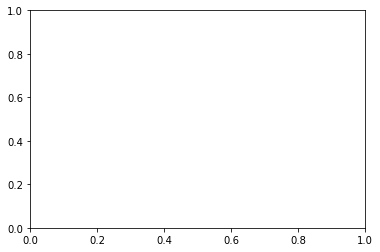

In [27]:
# Initialize the fig, ax
fig, ax = plt.subplots()

# plot roc curve
plot_roc(
    y_val, 
    val_preds, 
    'h1n1_vaccine',
    ax = ax
)

### 2. Naive Bayesian

#### 2.1 Baseline Model

Our second model will be Gaussian Naive Bayesian.

In [66]:
nb_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GaussianNB())
])

In [67]:
cross_validate(nb_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([4.36447573, 4.54512787, 4.18051982, 4.19180679, 3.73539996]),
 'score_time': array([0.10510349, 0.10609794, 0.10009074, 0.10109186, 0.09808826]),
 'test_score': array([0.76199392, 0.75520711, 0.76222794, 0.7516967 , 0.75567517]),
 'train_score': array([0.76029722, 0.75702083, 0.75579218, 0.75912708, 0.75889305])}

Cross validation shows that there is no overfitting.

In [68]:
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [69]:
nb_preds = nb_clf.predict(X_val)

In [70]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds)))

accuracy: 0.756
recall: 0.623
f1: 0.528
roc_auc: 0.708


Accuracy score is lower than Logistic Regression. However, recall, f1, ROC_AUC is higher than those of the baseline Logistic Regression Model.

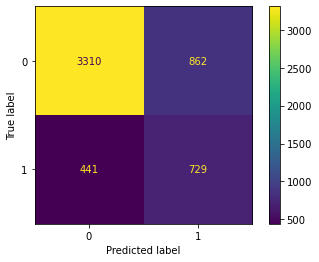

In [71]:
plot_confusion_matrix(nb_clf, X_val, y_val)

Confusion Matrix shows that recall is higher than Precision.

#### 2.2 Tuning

For GaussianNB, there is only one parameter to tune, which is var_smoothing.

In [72]:
params={'classifier__var_smoothing':np.logspace(0,-9, num=100),
       }

In [73]:
grid_nb = GridSearchCV(nb_clf, param_grid=params, scoring='f1')
output_nb = grid_nb.fit(X_train, y_train)

In [74]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(output_nb.best_params_, 
                                                  output_nb.best_score_))

Best Param:{'classifier__var_smoothing': 0.1873817422860384}, Best f1:0.539


The model with best f1 score is var_smoothing = 0.18738...

#### 2.2 Model 2.0

We will check the result for the model 2.0 with best parameter.

In [75]:
output_nb.best_estimator_.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [78]:
cross_validate(output_nb.best_estimator_, X_train, y_train, return_train_score=True)

{'fit_time': array([3.93057656, 4.87893677, 4.20482588, 4.248878  , 4.29090524]),
 'score_time': array([0.09909844, 0.11210179, 0.10410285, 0.13512325, 0.0990901 ]),
 'test_score': array([0.79194945, 0.79475778, 0.79569389, 0.78586473, 0.78539668]),
 'train_score': array([0.792359  , 0.78937515, 0.78972619, 0.7915399 , 0.79159841])}

Cross validation shows that there is no overfitting.

In [76]:
nb_preds2 = output_nb.best_estimator_.predict(X_val)

In [77]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, nb_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, nb_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, nb_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , nb_preds2)))

accuracy: 0.785
recall: 0.570
f1: 0.538
roc_auc: 0.708


The result shows there is no significant difference in our model after tuning except the recall score went down. We will check the confusion matrix.

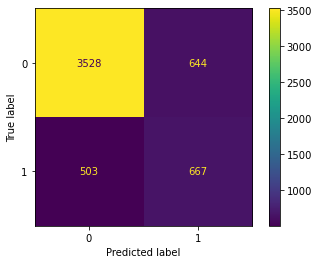

In [79]:
plot_confusion_matrix(output_nb.best_estimator_, X_val, y_val)

We can see that precision got larger and the plot seems more balanced out than baseline model.

#### 2.4 ROC Curve

Below is the ROC curve for the tuned GaussianNB

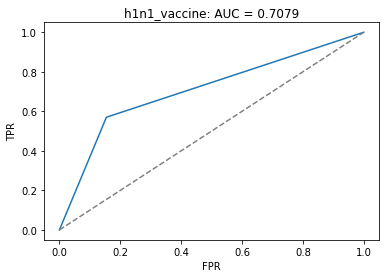

In [80]:
fig, ax = plt.subplots()
plot_roc(
    y_val, 
    nb_preds2, 
    'h1n1_vaccine',
    ax = ax
)

### 3. KNN

#### 3.1 Baseline Model

Our third model is the K-nearest neighbors. 

In [37]:
knn_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [38]:
knn_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [39]:
knn_preds = knn_clf.predict(X_val)

In [40]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, knn_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, knn_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, knn_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , knn_preds)))

accuracy: 0.799
recall: 0.250
f1: 0.353
roc_auc: 0.602


Every score seems really low else than accuracy. We will not try to tune this model since the KNN takes a lot of time to run and the model score does not seem promising.

## Random Forest

Our fourth model is Random Forest.

#### 4.1 Baseline Model

In [81]:
rf_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [82]:
cross_validate(rf_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([6.37982011, 6.55396342, 6.77817488, 6.87282896, 5.49900389]),
 'score_time': array([0.17916298, 0.17615271, 0.17615318, 0.19617057, 0.16515017]),
 'test_score': array([0.8567751 , 0.85279663, 0.85466885, 0.85326469, 0.84249941]),
 'train_score': array([1.        , 1.        , 0.99994149, 0.99994149, 1.        ])}

Cross validation score shows that the model is overfitting. The parameter tuning is needed to modify this.

In [83]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [84]:
rf_preds = rf_clf.predict(X_val)

In [85]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds)))

accuracy: 0.845
recall: 0.422
f1: 0.544
roc_auc: 0.693


Most of the score looks high enough. We might want to try out the grid search to modify the scores since the recall is the lowest out of the models we have tried (excluding KNN).

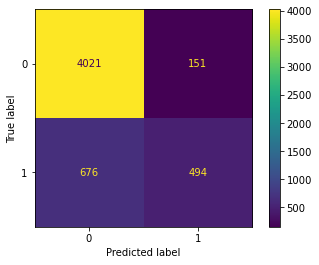

In [86]:
plot_confusion_matrix(rf_clf, X_val, y_val)

As we can see the precision is really high but recall is relatively low.

#### 5.2 Tuning

Since there are too many parameters, we went through 1 parameters at a time.

In [87]:
rf_params={#'classifier__criterion':['gini', 'entropy'],
           #'classifier__n_estimators':[100, 150, 200, 250, 300],
           #'classifier__min_samples_leaf':[1, 8, 12, 18],
           #'classifier__max_features':['auto','log2', None],
           #'classifier__max_depth':[None, 6, 8, 10, 12],
           #'classifier__max_leaf_nodes':[None, 10, 20, 30],
           #'classifier__class_weight':['balanced', 'balanced_subsample', None]
           
       }

In [88]:
grid_rf = GridSearchCV(rf_clf3, param_grid=rf_params, scoring='f1')
output_rf = grid_rf.fit(X_train, y_train)

In [89]:
print('Best Param:{0}, Best f1:{1:.3f}'.format(grid_rf.best_params_, 
                                               grid_rf.best_score_))

Best Param:{}, Best f1:0.568


The result of tuning is displayed below:
- class_weight = None
- criterion = entropy
- n_estimators = 300
- class weight = None
- max features = None
- max_leaf_nodes = None
- max_depth = None
- min_samples_leaf = 1

However, we could not find specific min_samples_split since we have to go through cross validation. We will try out the min_samples_split = 20 first and check if the model is still overfitting.

In [90]:
rf_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 20))
])

In [91]:
rf_clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [92]:
cross_validate(rf_clf2, X_train, y_train, return_train_score=True)

{'fit_time': array([31.98541975, 33.19978142, 31.89584231, 31.97439623, 30.83738232]),
 'score_time': array([0.30127382, 0.30027318, 0.29826355, 0.30127454, 0.29726267]),
 'test_score': array([0.85279663, 0.8542008 , 0.85396677, 0.85349871, 0.84717997]),
 'train_score': array([0.92060613, 0.92101568, 0.9186169 , 0.92160075, 0.92300491])}

The train score shows that our model is still overfitting. Lets try 100.

In [43]:
rf_clf3= Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 300, 
                                          criterion = 'entropy', 
                                          max_features = None, 
                                          min_samples_split = 100))
])

In [100]:
cross_validate(rf_clf3, X_train, y_train, return_train_score=True)

{'fit_time': array([27.60027742, 27.57715344, 27.55732226, 27.63543224, 27.79033494]),
 'score_time': array([0.27224779, 0.27224779, 0.27024555, 0.27525091, 0.2742424 ]),
 'test_score': array([0.85162649, 0.85326469, 0.85373274, 0.8525626 , 0.84600983]),
 'train_score': array([0.86479055, 0.86373742, 0.86549263, 0.86689679, 0.86619471])}

Our test and train score is close so min_samples_split = 100 successfully reduced the overfit.

In [44]:
rf_clf3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [45]:
rf_preds3 = rf_clf3.predict(X_val)

In [46]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, rf_preds3)))
print('recall: {:0.3f}'.format(recall_score(y_val, rf_preds3)))
print('f1: {:0.3f}'.format(f1_score(y_val, rf_preds3)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , rf_preds3)))

accuracy: 0.846
recall: 0.449
f1: 0.560
roc_auc: 0.703


Every score improved slightly. However, the recall is still low compared to other models.

### 6. Stack 

Since the Random Forest shows the low recall, Logistic Regression shows the low precision, and GaussianNB is balanced, we wondered if the stacking can create a model with best of all kind.

#### 6.1 Stack 1.0

We stacked all 3 models we previously mentioned, with the tuned parameters to see how the results end up.

In [95]:
stack_clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators = 300, 
                                                                                criterion = 'entropy', 
                                                                                max_features = None, 
                                                                                min_samples_split = 100, 
                                                                                max_depth = None)),
                                                 ('nb',GaussianNB(var_smoothing= 0.1873817422860384))],
                                     final_estimator = LogisticRegression(C= 10, 
                                                                          class_weight= 'balanced', 
                                                                          penalty = 'l2')))
])

In [96]:
cross_validate(stack_clf, X_train, y_train, return_train_score=True)

{'fit_time': array([114.63306808, 122.07324767, 117.29504037, 115.73042107,
        113.61356616]),
 'score_time': array([0.28025436, 0.28025508, 0.28226495, 0.27726007, 0.26924586]),
 'test_score': array([0.81465013, 0.81371402, 0.82354318, 0.81043763, 0.79873625]),
 'train_score': array([0.83606366, 0.83635619, 0.83565411, 0.83594664, 0.83799438])}

The cross validation shows there is no significant overfit.

In [97]:
stack_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [98]:
stack_preds = stack_clf.predict(X_val)

In [99]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, stack_preds)))
print('recall: {:0.3f}'.format(recall_score(y_val, stack_preds)))
print('f1: {:0.3f}'.format(f1_score(y_val, stack_preds)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , stack_preds)))

accuracy: 0.809
recall: 0.711
f1: 0.620
roc_auc: 0.774


The result shows that stacked model created a best results for every scores; every score reached the near highest score. However, lets also try out the model with only Random Forest and Logistic Regression since those two are inverse in recall and precision scores.

#### Stack 2.0

Stack 2.0 will stack Random Forest and Logistic Regression.

In [48]:
stack_clf2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', StackingClassifier(estimators=[('rf', RandomForestClassifier(n_estimators = 300, 
                                                                                criterion = 'entropy', 
                                                                                max_features = None, 
                                                                                min_samples_split = 100, 
                                                                                max_depth = None))],
                                     final_estimator = LogisticRegression(C= 10, 
                                                                          class_weight= 'balanced', 
                                                                          penalty = 'l2')))
])

In [49]:
cross_validate(stack_clf2, X_train, y_train, return_train_score=True)

{'fit_time': array([118.91603112, 115.26718497, 111.2928021 , 112.45765901,
        109.86758161]),
 'score_time': array([0.25523996, 0.2552402 , 0.25623298, 0.25523233, 0.2502346 ]),
 'test_score': array([0.81277791, 0.81675638, 0.82213901, 0.81207582, 0.80037444]),
 'train_score': array([0.8398081 , 0.83863796, 0.83857945, 0.83699977, 0.84109525])}

Cross validation does not show the sign of significant overfitting.

In [50]:
stack_clf2.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('minmaxscaler',
                                                                   MinMaxScaler()),
                                                                  ('num_imputer',
                                                                   IterativeImputer(max_iter=15))]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                    

In [51]:
stack_preds2 = stack_clf2.predict(X_val)

In [52]:
print('accuracy: {:0.3f}'.format(accuracy_score(y_val, stack_preds2)))
print('recall: {:0.3f}'.format(recall_score(y_val, stack_preds2)))
print('f1: {:0.3f}'.format(f1_score(y_val, stack_preds2)))
print('roc_auc: {:0.3f}'.format(roc_auc_score(y_val , stack_preds2)))

accuracy: 0.808
recall: 0.700
f1: 0.615
roc_auc: 0.769


The result shows slightly worse score for all. Therefore, stacking all 3 models will be a better model.

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [ ]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [ ]:
# code here for your first 'substandard' model

In [ ]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [ ]:
# code here to iteratively improve your models

In [ ]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [ ]:
# code here to show your final model

In [ ]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
